# **핸즈온 머신러닝 CHAP 3 p127~154** 

### **3.1 MNIST**

MNIST: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 데이터셋

In [18]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

MNIST 구조
* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [3]:
X, y =mnist['data'], mnist['target']
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

* 이미지는 총 70000개 (28x28픽셀)
* 픽셀 강도: 0(흰색)~ 255(검은색)

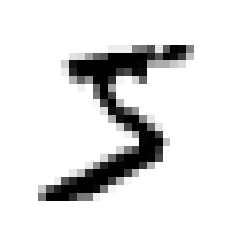

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit= X.to_numpy()[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

In [13]:
# 레이블은 문자열, 숫자로 변환
import numpy as np
y = y.astype(np.uint8)

데이터를 조사하기 전에 테스트 세트를 따로 분리해야 함. MNIST 데이터셋은 이미 훈련 세트 (앞쪽 60,000개)와 테스트 세트 (뒤쪽 10,000개)로 나눠진 것.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **3.2 이진 분류기 훈련**

In [11]:
y_train_5 = (y_train == 5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

확률적 경사 하강법(SGD)
- 매우 큰 데이터셋을 효율적으로 처리하는 장점 (한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문)
- 이러한 특성 덕분에 SGD는 온라인 학습에 잘 맞는 편.
- 무작위성을 사용해 훈련하기 때문에 random_state 매개변수 지정해야 함.

In [19]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

ValueError: The number of classes has to be greater than one; got 1 class

In [16]:
sgd_clf.predict([some_digit])

IndexError: tuple index out of range

### **3.3 성능 측정**

#### 3.3.1 교차 검증을 사용한 정확도 측정

In [1]:
# 사이킷런의 cross_val_score() 함수와 거의 같은 작업 수행
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

NameError: name 'X_train' is not defined

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [14]:
 never_5_clf = Never5Classifier()
 cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

무조건 '5 아님'으로 예측하면 맞출 확률이 90%이상 
> 불균형한 데이터셋을 다룰 때(즉, 어떤 클래스가 다른 것보다 월등히 많은 경우) 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유



#### 3.3.2 오차 행렬

클래스 A의 샘플이 클래스 B로 분류된 횟수 세기

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

> cross_val_score(): k fold 교차 검증을 수행하지만 평가 점수 대신 각 테스트 폴드에서 얻은 예측 반환

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

행: 실제 클래스, 열: 예측한 클래스, 음성 클래스: '5아님' 이미지, 양성 클래스: '5'이미지
* TN(true negative): 음성으로 분류하고 실제 음성
* FP(false positive): 양성으로 분류하고 실제 음성
* FN(false negative): 음성으로 분류하고 실제 양성
* TP(true postive): 양성으로 분류하고 실제 양성

In [17]:
y_train_perfect_predictions = y_train_5 # 완벽한 분류기의 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**식 3-1** 정밀도: TP/(TP+FP)

**식 3-2** 재현율: TP/(TP+FN)

결과 |음성 예측| 양성 예측
----------|---------|-----------
실제 음성|TN(true negative)        |FP(false positive)
실제 양성|FN(false negative)       |TP(true positive)




#### 3.3.3 정밀도와 재현율

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

**식 3-3** F1 score: 정밀도와 재현율의 조화평균

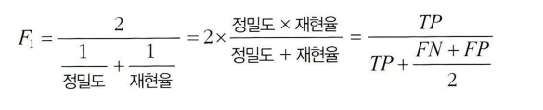

In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

* 정밀도와 재현율이 비슷한 분류기에서는 F1 점수 높음.

#### 3.3.4 정밀도/재현율 트레이드오프


**정밀도/재현율 트레이드 오프**: if 정밀도↑ 재현율↓ 그 반대의 경우도 마찬가지.

분류기는 결정함수(decision function)를 사용하여 각 샘플의 점수가 임곗값보다 크면 양성 클래스에, 그렇지 않으면 음성 클래스에 할당함

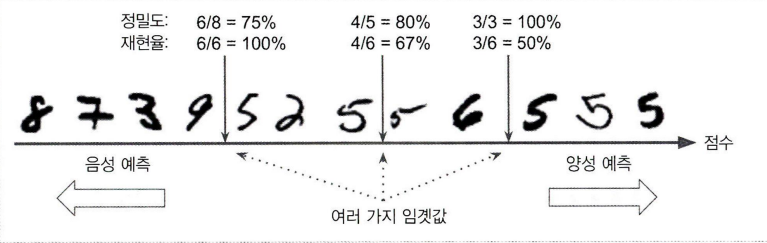

분류기가 만든 점수 순으로 나열됨. 임곗값이 높을수록 재현율은 낮아지고 반대로 (보통) 정밀도는 높아짐.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
# SGDClassifier의 임곗값이 0이므로 predict() 와 같은 결과(true)를 반환했음
# 차이를 보기 위해 임곗값을 높임

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

→ 적절한 임곗값을 정하기 위해 cross_val_predict() 사용해서 훈련 세트에 있는 모든 샘플의 점수를 구해야 함.

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method='decision_function') # 결정 점수를 반환하도록 지정

In [25]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


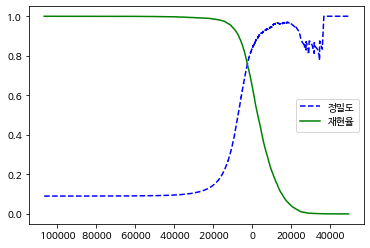

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
  plt.legend()
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

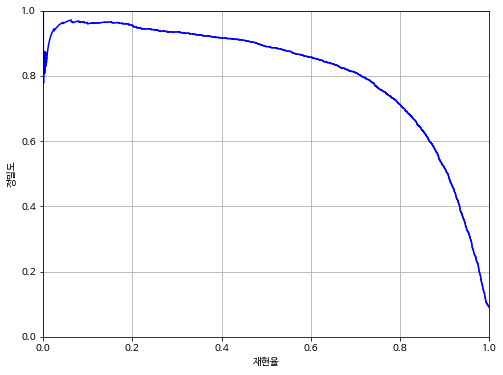

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("재현율")
    plt.ylabel("정밀도")
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.grid()
plt.show()

* 재현율 80% 근처에서 정밀도가 급격히 하강
* 하강점 직전을 정밀도/재현율 트레이드오프로 선택

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

* 정밀도를 높여도 재현율이 너무 낮으면 안 됨.

#### 3.3.5 ROC 곡선

수신기 조작 특성(ROC): 진짜 양성 비율(TPR) / 거짓 양성 비율(FPR)

* TPR: 재현율, 민감도
* TNR: 특이도(specificity)
* FPR: 1- TNR

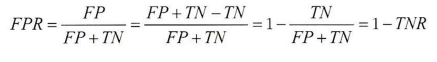

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

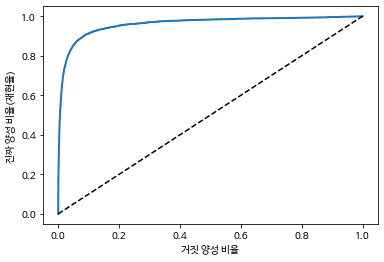

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--') # 대각 점선
  plt.xlabel("거짓 양성 비율")
  plt.ylabel("진짜 양성 비율(재현율)")

plot_roc_curve(fpr, tpr)
plt.show()

* 재현율(TPR)이 높을수록 FPR 증가
* 점선은 완전한 랜덤 분류기의 ROC 곡선
* 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함 (좌측 상단 모서리)
* 곡선 아래의 면적(AUC)을 측정했을 때, 완전한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5 (ROC 곡선이 y=x에 가깝게 되기 때문, FPR과 TPR 값이 비슷해짐을 의미)

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                     method='predict_proba')
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

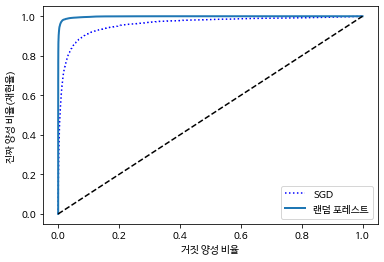

In [45]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, '랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

RandomForestClassifier의 ROC 곡선이 SGDClassifier보다 좋음.

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### **3.4 다중 분류** 

**다중 분류기(multiclass classifier)**: 둘 이상의 클래스 구별 (ex. SGD, RF, 나이브베이즈 등)

cf) 이진 분류기(binary classifier): 로지스틱 회귀, SVM 등

---
특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들었다고 가정했을 때,
* OvR(or OvA): 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
* OvO: 0과 1구별, 0과 2구별 등 각 숫자의 조합마다 이진 분류기 훈련 (클래스가 N개라면 분류기는 N*(N-1)/2개 필요). 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽을 선호할 때 쓰임(SVM 등)


In [47]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train_5가 아니고 y_train 
svm_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([5], dtype=uint8)

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [50]:
np.argmax(some_digit)


161

In [51]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
svm_clf.classes_[5]

5

In [49]:
# OneVsOneClassifier(OvO) or OneVsRestClassifier(OvR)

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([3], dtype=uint8)

In [56]:
# SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도의 OvR이나 OvO 적용 안 해도 된다.
# decision_function(): 클래스마다 하나의 값 반환

sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [58]:
# 스케일 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### **3.5 에러분석**

목적: 모델의 성능 향상

에러비율: 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나눈 것

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

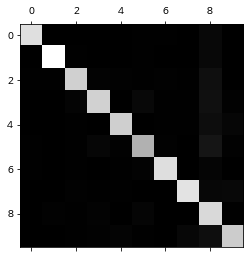

In [60]:
plt.matshow(conf_mx, cmap=plt.cm.gray) # matshow(): 이미지 표현
plt.show()

* 배열에서 가장 큰 값은 흰색, 가장 작은 값은 검은색으로 정규화
* 숫자 5는 다른 숫자보다 조금 더 어두워보인다. 
  * case 1. 숫자 5의 이미지가 적음
  * case 2. 분류기가 숫자 5를 다른 숫자만큼 분류하지 못함 

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

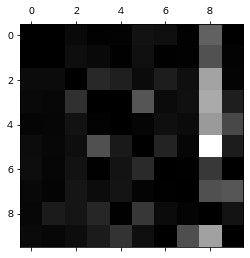

In [64]:

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

행: 실제 클래스\
열: 예측한 클래스



In [65]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

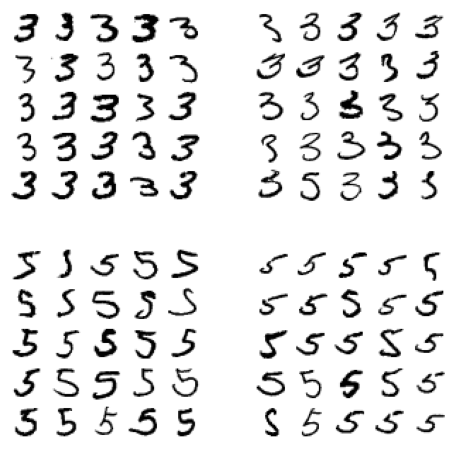

In [66]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

왼쪽의 5x5 블록 두 개는 3으로 분류된 이미지이고 오른쪽 5x5 블록 두 개는 5로 분류된 이미지이다.

오류 원인은 선형모델인 SGDClassifier 사용

∵ 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산. 쉽게 혼동.

### **3.6 다중 레이블 분류**

**다중 레이블 분류(multilabel classification)**: 여러 개의 이진 꼬리표를 출력하는 분류

※ KneighborsClassifier는 다중 레이블 분류를 지원하지만, 모든 분류기가 그런 것은 아니다.

In [67]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [68]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([[False,  True]])

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

> 이 코드는 모든 레이블의 가중치가 같다고 가정한 것. 가중치를 주기 위해서는 지지도(타깃 레이블에 속한 샘플 수)를 활용 (average='weighted')

### **3.7 다중 출력 분류**

**다중 출력 다중 클래스 분류**: 다중 레이블 분류에서 한 레이블이 다중 클래스가 되도록 일반화한 것(값을 두 개 이상 가질 수 있다).

이미지 잡음 제거 시스템
* 입력: 잡음이 많은 숫자 이미지
* 출력: 깨끗한 숫자 이미지를 MNIS 이미지처럼 픽셀의 강도를 담은 배열
* 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가진다(0~255의 픽셀 강도)

In [70]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [71]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)